In [ ]:
pip install MTCNN

In [ ]:
#aight, so you need MTCNN for face detection, makes life easy don't wanna make another YOLO alg
#and for some reason you can't place a comment above the pip install, OCD dudes, get rekt
import numpy as np 
import pandas as pd 
import os
import sys
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from mtcnn.mtcnn import MTCNN

In [ ]:
print(tf.__version__)
print(keras.__version__)
sys.version_info

2.3.0
2.4.0


sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)

In [ ]:
#babayoda googur drivuuuu
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#rootdirectory - change ber user
root_dir = "/content/drive/My Drive/facemask/face-mask-detection-dataset/"

In [ ]:
#just linking, nothing fun
images       = os.path.join(root_dir + "Medical mask/Medical mask/Medical Mask/images")
annotations  = os.path.join(root_dir + "Medical mask/Medical mask/Medical Mask/annotations")

In [ ]:
#read em csvs
train        = pd.read_csv( os.path.join(root_dir + "train.csv" ))
submission   = pd.read_csv( os.path.join(root_dir + "submission.csv" ))

In [ ]:
#meh formalities
print(len(train))
train.head()

15412


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [ ]:
cols = []

for i in range(len(train)):
    if train['classname'].iloc[i] not in cols:
        cols.append(train['classname'].iloc[i])
cols

['face_with_mask', 'face_no_mask']

In [ ]:
masks = ['face_with_mask', 'mask_colorful', 'mask_surgical', 'face_shield', 'gas_mask']

In [ ]:
for i in range(len(train)):
    if train['classname'].iloc[i] in masks:
        train['classname'].iloc[i] = 'face_with_mask'
    else:
        train['classname'].iloc[i] = 'face_no_mask'


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
faceMask = 0
nofaceMask = 0
other = 0

for i in range(len(temp_train)):
    if train['classname'].iloc[i] == "face_with_mask":
        faceMask+=1
    elif train['classname'].iloc[i] == "face_no_mask":
        nofaceMask+=1
    else:
        other+=1

print(other)
print(faceMask)
print(nofaceMask)

0
7562
5860


In [ ]:
print(len(submission))
submission.head()


8142


,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN


In [ ]:
len(os.listdir(images))

6031

In [ ]:
#sort em files based on numbers so json and imgs are mapped
a=os.listdir(images)
b=os.listdir(annotations)
a.sort()
b.sort()

In [ ]:
print(len(b),len(a))

4328 6031


In [ ]:
#train has everything that's from 1nice8 onwards
train_images=a[1698:]
test_images=a[:1698]

In [ ]:
test_images[0]

'0001.jpg'

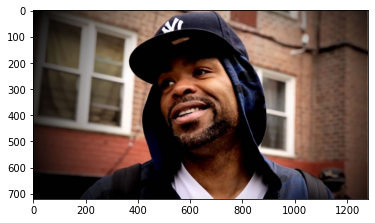

In [ ]:
#meh
img=plt.imread(os.path.join(images,test_images[0]))
plt.imshow(img)
plt.show()

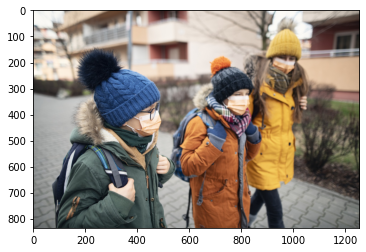

In [ ]:
img=plt.imread(os.path.join(images,train_images[1]))
plt.imshow(img)
plt.show()

In [ ]:
#setting the output class to "yep, mask" and "yep, no mask", and then re-arrange based on current labels of Y for ease of manual analysis
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)]
train.sort_values('name',axis=0,inplace=True)

[[451, 186, 895, 697]]


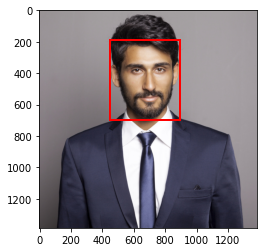

In [ ]:
#juking them trains into that bbox so we can see red rectangles around the faces

bbox=[]
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]: #yup, the 4 corners of a BOX
        arr.append(j)
    bbox.append(arr)

train["bbox"]=bbox  

def get_boxes(id):
    boxes=[]
    for i in train[train["name"]==str(id)]["bbox"]: #mapping the name and id for CONCURRENCY
        boxes.append(i)
    return boxes

#Brint the boundaries
print(get_boxes(train_images[3])) 

#load image into img
image=train_images[3]
img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)

#draw them lines from the set of boxes on the img
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

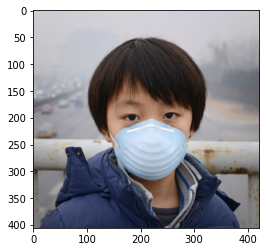

In [ ]:
#yeah, yeah same thing nothing fun here, 

image=train_images[5]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

<BarContainer object of 2 artists>

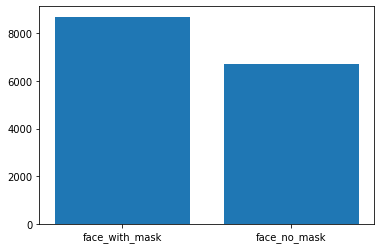

In [ ]:
plt.bar(['face_with_mask','face_no_mask'],train.classname.value_counts())

In [ ]:
filter_train = train
print(len(filter_train))
print(nofaceMask)

15412
5860


In [ ]:
temp_train = filter_train[filter_train.classname != 'face_no_mask']

In [ ]:
face_temp_train = filter_train[filter_train.classname != 'face_with_mask']

In [ ]:
temp_train = temp_train[:-1990] 
temp_train = temp_train.append(face_temp_train, ignore_index = True)

In [ ]:
len(temp_train)

13422

In [ ]:
temp_train = temp_train.sample(frac =1) 

In [ ]:
temp_train.head()

,name,x1,x2,y1,y2,classname
7993,5171.jpg,619,114,696,138,face_no_mask
11958,4958.png,131,49,518,547,face_no_mask
13302,3591.png,67,0,156,48,face_no_mask
9403,5568.png,258,361,480,522,face_no_mask
3973,3415.png,360,67,389,134,face_with_mask


<BarContainer object of 2 artists>

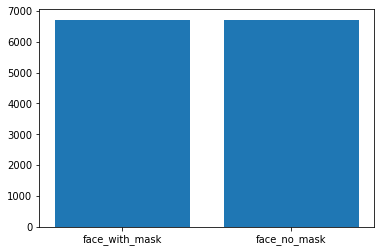

In [ ]:
plt.bar(['face_with_mask','face_no_mask'],temp_train.classname.value_counts())

In [ ]:
train = temp_train

In [ ]:
train[1:20]

,name,x1,x2,y1,y2,classname
3718,4826.png,305,147,346,181,face_with_mask
11880,4612.png,105,0,611,239,face_no_mask
11879,5500.jpg,713,422,863,582,face_no_mask
1341,2049.jpg,839,611,1994,2139,face_with_mask
12635,3590.png,337,11,397,37,face_no_mask
807,4468.png,164,334,492,592,face_with_mask
11818,6125.jpg,147,99,754,748,face_no_mask
5950,3427.png,428,137,474,179,face_with_mask
7921,3315.png,107,101,394,278,face_no_mask
7721,3295.png,3,1,124,119,face_no_mask


In [ ]:
#resizing images takes like 10 min (690.83s), smh

img_size=50
data=[]

#path setting for directory
path= root_dir + 'Medical mask/Medical mask/Medical Mask/images/' 
def create_data():
       for i in range(len(train)):
            arr=[]
            for j in train.iloc[i]:
                   arr.append(j)
            #unrolling? the jpegs into respective (H*W*3) arrays cuz color
            img_array=cv2.imread(os.path.join(images,arr[0]),cv2.IMREAD_GRAYSCALE)
            #ok it's grayscale, that didn't age well (H*W*1) dims 
            #yeet out the stuff that isn't the face 
            crop_image = img_array[arr[2]:arr[4],arr[1]:arr[3]]
            new_img_array=cv2.resize(crop_image,(img_size,img_size))

            #slap the new images into this new ummmm thingy
            data.append([new_img_array,arr[5]])
            
            if i % 1000 == 0:
                print(str(i) + " loaded")
create_data()      

0 loaded
1000 loaded
2000 loaded
3000 loaded
4000 loaded
5000 loaded


error: ignored

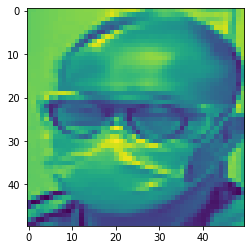

In [ ]:
    #yes, YES, YESSS!!!! only the face
data[124][0]
plt.imshow(data[124][0])

In [ ]:
#standard 'meh' stuff for linking em labels with images
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y=lbl.fit_transform(y)

In [ ]:
#more standard boring stuff, reshaping the images and normalizing to make umm something about training faster, idk
x=np.array(x).reshape(-1,50,50,1)
x=tf.keras.utils.normalize(x,axis=1)
from keras.utils import to_categorical
y = to_categorical(y)

In [ ]:
#printing the shapes, cuz was bored
print("Shape of X: " + str(x[0].shape) )
print("Shape of Y: " + str(y[0].shape) )

Shape of X: (50, 50, 1)
Shape of Y: (2,)


In [ ]:
#wasn't frisky so i made a simple CNN, also loading google servers slow on free tier

from keras.layers import LSTM
model=Sequential()
model.add(Conv2D(100,(3,3),input_shape=x.shape[1:],activation='relu',strides=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))


In [ ]:
#training takes like 7 minutes (414.71s)

opt = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
model.fit(x,y,epochs=30,batch_size=5)

Epoch 1/30
1062/1062 [==============================] - 12s 11ms/step - loss: 0.6473 - accuracy: 0.6199
Epoch 2/30
1062/1062 [==============================] - 12s 11ms/step - loss: 0.5814 - accuracy: 0.6903
Epoch 3/30
1062/1062 [==============================] - 12s 11ms/step - loss: 0.5402 - accuracy: 0.7197
Epoch 4/30
1062/1062 [==============================] - 12s 11ms/step - loss: 0.5195 - accuracy: 0.7427
Epoch 5/30
1062/1062 [==============================] - 12s 11ms/step - loss: 0.4914 - accuracy: 0.7559
Epoch 6/30
1062/1062 [==============================] - 12s 11ms/step - loss: 0.4699 - accuracy: 0.7708
Epoch 7/30
1062/1062 [==============================] - 12s 11ms/step - loss: 0.4585 - accuracy: 0.7807
Epoch 8/30
1062/1062 [==============================] - 12s 12ms/step - loss: 0.4355 - accuracy: 0.7945
Epoch 9/30
1062/1062 [==============================] - 12s 11ms/step - loss: 0.4139 - accuracy: 0.8066
Epoch 10/30
1062/1062 [==============================] - 12s 11m

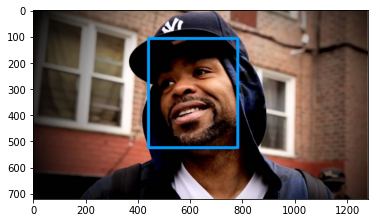

In [ ]:
#yup, boring stuff here. face detector using the MTCNN thingy that we installed in the start, when dinos roamed the earth

detector=MTCNN()
img=plt.imread(os.path.join(images,test_images[0]))
face=detector.detect_faces(img)

'''
draw the boxes, draw the boxes
on all the images, on all the images
at this time i got bored, and i went to walk. i think so
'''

for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)

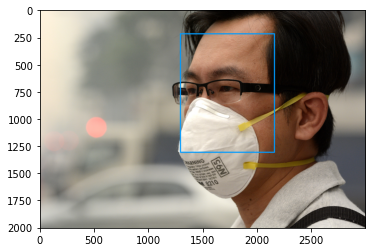

In [ ]:
img=plt.imread(os.path.join(images,test_images[2]))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)

In [ ]:
model.predict(test_images[2])

IndexError: ignored

In [ ]:
#it's been running for 40 min now, bruh wtf

detector=MTCNN()
test_df=[]
#now we saucing out the test stuff, oooh fun :kappa:
#find those faces and box em all up
for image in test_images:
    img=plt.imread(os.path.join(images,image))
    faces=detector.detect_faces(img)
    test=[]
    for face in faces:
        bounding_box=face['box']
        test.append([image,bounding_box])
    test_df.append(test)

test=[]

#append in "yup, mask" or "yup, no mask"
for i in test_df:
    if len(i)>0:
        if len(i)==1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)  

sub=[]
rest_image=[]

#meh, we could have messed up on attempt one, you guys
#so we roll them again the way snoop does, kekw

for i in test:
    sub.append(i[0])
for image in test_images:
    if image not in sub:
        rest_image.append(image) 

detector=MTCNN()
test_df_=[]

#box em up
for image in rest_image:
    img=cv2.imread(os.path.join(images,image))
    faces=detector.detect_faces(img)
    test_=[]
    for face in faces:
        bounding_box=face['box']
        test_.append([image,bounding_box])
    test_df_.append(test_) 

for i in test_df_:
    if len(i)>0:
        if len(i)==1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)      

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#all wrong calls are listed (here it's the ones with the negative value on face locations)
negative=[]
for i in test:
    for j in i[1]:
        if j<0:
            negative.append(i)
    

In [ ]:
#hard coding those cuz we already have them from the source, RIGHT, hmmmm!!!!

test_data=[]
def create_test_data():
            for j in test:
                if j not in negative:
                    img=cv2.imread(os.path.join(images,j[0]),cv2.IMREAD_GRAYSCALE)
                    img=img[j[1][1]:j[1][1]+j[1][3],j[1][0]:j[1][0]+j[1][2]]
                    new_img=cv2.resize(img,(50,50))
                    new_img=new_img.reshape(-1,50,50,1)
                    predict=model.predict(new_img)
                    #print(predict)
                    test_data.append([j,predict])

create_test_data()      

In [ ]:
#filling in a csv the image id, the output, and the face boxing 
image=[]
classname=[]
for i,j in test_data:
    classname.append(np.argmax(j))
    image.append(i)
df=pd.DataFrame(columns=['image','classname'])
df['image']=image
df['classname']=classname
df['classname']=lbl.inverse_transform(df['classname'])
image=[]
x1=[]
x2=[]
y1=[]
y2=[]
for i in df['image']:
    image.append(i[0])
    x1.append(i[1][0])
    x2.append(i[1][1])
    y1.append(i[1][2])
    y2.append(i[1][3])
df['name']=image
df['x1']=x1
df['x2']=x2
df['y1']=y1
df['y2']=y2    
df.drop(['image'],axis=1,inplace=True)

In [ ]:
df.sort_values('name',axis=0,inplace=True,ascending=False)
df.to_csv(root_dir + 'res1.csv')

In [ ]:
#beyond this is the graveyard and area51 test zone. 
#welcome (-:









In [ ]:
test_real_images       = os.path.join(root_dir + "Medical mask/Medical mask/Medical Mask/test-images")

In [ ]:
os.listdir(test_real_images)

['person_no_mask.jpeg',
 'person_with_mask.jpeg',
 'shank_mask.jpg',
 'shank_no.jpg']

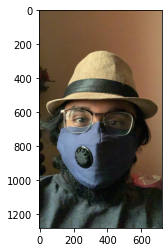

In [ ]:
img=plt.imread(os.path.join(test_real_images,'person_with_mask.jpeg'))
plt.imshow(img)
plt.show()

detector=MTCNN()
img=plt.imread(os.path.join(test_real_images,'person_with_mask.jpeg'))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)

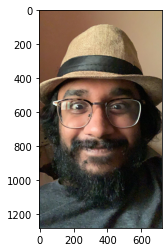

In [ ]:
img=plt.imread(os.path.join(test_real_images,'person_no_mask.jpeg'))
plt.imshow(img)
plt.show()

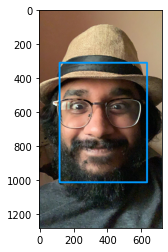

In [ ]:
detector=MTCNN()
img=plt.imread(os.path.join(test_real_images,'person_no_mask.jpeg'))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)

[[1.000000e+00 7.684966e-20]
 [1.000000e+00 0.000000e+00]
 [0.000000e+00 1.000000e+00]]
[[0. 1.]]
mask


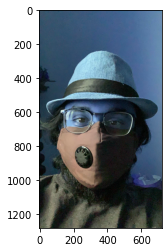

In [ ]:
img_num = "person_with_mask"

img=cv2.imread(os.path.join(test_real_images,img_num+'.jpeg'))
plt.imshow(img)
new_img=cv2.resize(img,(50,50))
new_img=new_img.reshape(-1,50,50,1)
predict=model.predict(new_img)
print(predict)

img=cv2.imread(os.path.join(test_real_images,img_num+'.jpeg'),cv2.IMREAD_GRAYSCALE)
new_img=cv2.resize(img,(50,50))
new_img=new_img.reshape(-1,50,50,1)
predict=model.predict(new_img)
print(predict)

if predict[0][0] == 1:
    print("no ")
print("mask")

In [ ]:
model.predict(data[124][0])

ValueError: ignored

In [ ]:
#saving the model for export to some other country, yep unlike us these people can move
model.save('saves-edit')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saves-edit/assets


In [ ]:
#for some reason i was tryng to export and import weights, why do that for oil when you can for gold
model.load_weights(root_dir + "")

In [ ]:
#690 KB file that contains all the stuff to run the prog

import numpy as np
import tensorflow as tf
import os
import cv2
from tensorflow import keras

root_dir = "/content/drive/My Drive/facemask/face-mask-detection-dataset/"
model = keras.models.load_model("saves-edit")

test_real_images       = root_dir + "Medical mask/Medical mask/Medical Mask/test-images"
img_num = "person_no_mask"

img=cv2.imread(os.path.join(test_real_images,img_num+'.jpeg'))
#plt.imshow(img)
new_img=cv2.resize(img,(50,50))
new_img=new_img.reshape(-1,50,50,1)
predict=model.predict(new_img)
print(predict)

img=cv2.imread(os.path.join(test_real_images,img_num+'.jpeg'),cv2.IMREAD_GRAYSCALE)
new_img=cv2.resize(img,(50,50))
new_img=new_img.reshape(-1,50,50,1)
predict=model.predict(new_img)
print(predict)

if predict[0][0] == 1:
    print("no ")
print("mask")

[[1. 0.]
 [0. 1.]
 [1. 0.]]
[[0. 1.]]
mask


In [ ]:
path = "steve"
a = os.path.join("hello")
a

'hello'

In [ ]:
#starting to think this should be in the start of the program, meh who cares
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_220 (Conv2D)          (None, 24, 24, 100)       1000      
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 12, 12, 100)       0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 10, 10, 64)        57664     
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_130 (Dense)            (None, 50)                80050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)               